# 3D Cardiac Segmentation (UNET vs UNETR)

In [1]:
unet_r = False
load_previous_model = False
epochs = 50

## Setup environment

In [2]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"

You should consider upgrading via the 'c:\users\alex\gitlab_repos\cardiacsegmentation\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [4]:
import os
from datetime import datetime
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.transforms import (
    Activations,
    AsDiscrete,
    KeepLargestConnectedComponent,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandZoomd,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ScaleIntensityRangePercentiles,
    NormalizeIntensityd
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, UNet, BasicUnet
from monai.visualize import blend_images, plot_2d_or_3d_image
from monai.data import (
    DataLoader,
    Dataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

c:\users\alex\gitlab_repos\cardiacsegmentation\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.2.dev2302
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 708e1a1cf4a1d5516eaf65b8a0bee8887cdee494
MONAI __file__: c:\users\alex\gitlab_repos\cardiacsegmentation\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/la

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
# Directory for saving my models and tensorboard data
root_dir = os.path.join(os.getcwd(), '')
print(root_dir)

# Directory for saving final test segmentations
if unet_r:    
    test_data_save_dir = os.path.join(os.getcwd(), 'UNETR') 
else:
    test_data_save_dir = os.path.join(os.getcwd(), 'UNET')

C:\Users\Alex\Gitlab_repos\CardiacSegmentation\MONAI_DATA_DIRECTORY


## Setup transforms for training and validation

In [7]:
# NORMALIZE VALUES INSTEAD OF FIXING A RANGE
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        NormalizeIntensityd(keys=["image"]),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandZoomd(keys=["image", "label"], prob=0.3, min_zoom=0.9, max_zoom=1.5, mode='nearest'),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.05,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        NormalizeIntensityd(keys=["image"]),
    ]
)

 ## Download dataset and format in the folder.
    1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json
    Example of JSON file:
     {
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        "imagesTs/img0061.nii.gz",
        "imagesTs/img0062.nii.gz",
        "imagesTs/img0063.nii.gz"
    ],
    "training": [
        {
            "image": "imagesTr/img0001.nii.gz",
            "label": "labelsTr/label0001.nii.gz"
        },
        {
            "image": "imagesTr/img0002.nii.gz",
            "label": "labelsTr/label0002.nii.gz"
        },
        {
            "image": "imagesTr/img0003.nii.gz",
            "label": "labelsTr/label0003.nii.gz"
        }
    ],
    "validation": [
        {
            "image": "imagesTr/img0035.nii.gz",
            "label": "labelsTr/label0035.nii.gz"
        },
        {
            "image": "imagesTr/img0036.nii.gz",
            "label": "labelsTr/label0036.nii.gz"
        },
        {
            "image": "imagesTr/img0037.nii.gz",
            "label": "labelsTr/label0037.nii.gz"
        }
    ]
}
    

In [8]:
datasets = "dataset.json"
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
test_files = load_decathlon_datalist(datasets, True, "test")


train_ds = Dataset(
    data=datalist,
    transform=train_transforms
)

train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=8
)

val_ds = Dataset(
    data=val_files,
    transform=val_transforms
)

val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=8
)


test_ds = Dataset(
    data=test_files,
    transform=val_transforms
)

test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=8
)

In [9]:
#Training:
print('Training data loading verification')
for step, batch in enumerate(train_loader):
    tmp = batch
    break

Training


In [10]:
#Validation:
print('Validation data loading verification')
for step, batch in enumerate(val_loader):
    tmp = batch
    break

Validation:


## Check data shape and visualize

In [11]:
case_num = 0
for step, batch in enumerate(val_loader):
    tmp = batch
    break
# tmp = val_ds[case_num]
img = tmp["image"]
label = tmp["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")

image shape: torch.Size([1, 1, 128, 128, 128]), label shape: torch.Size([1, 1, 128, 128, 128])


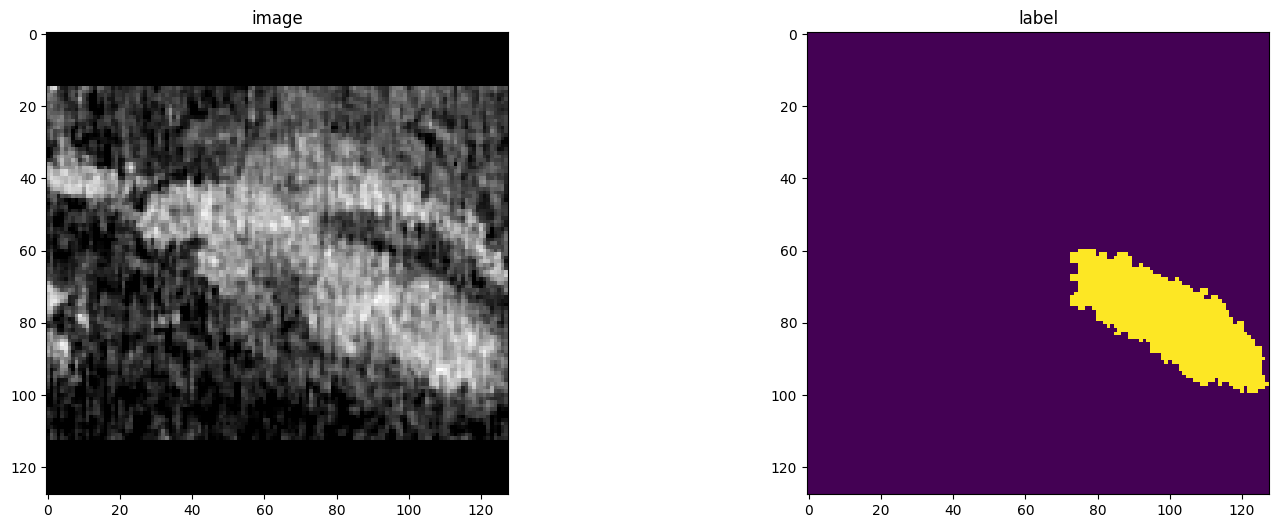

In [12]:
slice_preview = 64
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, 0, :, :, slice_preview].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, 0, :, :, slice_preview].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [13]:
# UNETR (Transformer)
if unet_r:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = UNETR(
        in_channels=1,
        out_channels=1,
        img_size=(128,128,128),
        feature_size=32,
        hidden_size=364,
        mlp_dim=3072,
        num_heads=12,
        pos_embed="perceptron",
        norm_name="instance",
        res_block=True,
        dropout_rate=0.0,
    ).to(device)

    summary(model, (1, 128, 128, 128))

    loss_function = DiceCELoss(sigmoid=True)
    torch.backends.cudnn.benchmark = True
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=8, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
    model_save_name = os.path.join(root_dir, "best_metric_model_unetr.pth")
    if load_previous_model:
        model.load_state_dict(torch.load(model_save_name))

In [15]:
# Basic Unet
if not unet_r:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BasicUnet(
        spatial_dims=3, 
        in_channels=1, 
        out_channels=1, 
        features=(32, 32, 64, 128, 256, 32), 
        act=('LeakyReLU', {'negative_slope': 0.1, 'inplace': True}), 
        norm=('instance', {'affine': True}), 
        bias=True, 
        dropout=0.0, 
        upsample='deconv'
    ).to(device)

    summary(model, (1, 128, 128, 128))

    loss_function = DiceCELoss(sigmoid=True)
    torch.backends.cudnn.benchmark = True
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=4, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
  
    model_save_name = os.path.join(root_dir, "best_metric_model_unet.pth")
    if load_previous_model:
        model.load_state_dict(torch.load(model_save_name))

BasicUNet features: (32, 32, 64, 128, 256, 32).
Layer (type:depth-idx)                   Output Shape              Param #
├─TwoConv: 1-1                           [-1, 32, 128, 128, 128]   --
|    └─Convolution: 2-1                  [-1, 32, 128, 128, 128]   --
|    |    └─Conv3d: 3-1                  [-1, 32, 128, 128, 128]   896
|    |    └─ADN: 3-2                     [-1, 32, 128, 128, 128]   64
|    └─Convolution: 2-2                  [-1, 32, 128, 128, 128]   --
|    |    └─Conv3d: 3-3                  [-1, 32, 128, 128, 128]   27,680
|    |    └─ADN: 3-4                     [-1, 32, 128, 128, 128]   64
├─Down: 1-2                              [-1, 32, 64, 64, 64]      --
|    └─MaxPool3d: 2-3                    [-1, 32, 64, 64, 64]      --
|    └─TwoConv: 2-4                      [-1, 32, 64, 64, 64]      --
|    |    └─Convolution: 3-5             [-1, 32, 64, 64, 64]      27,744
|    |    └─Convolution: 3-6             [-1, 32, 64, 64, 64]      27,744
├─Down: 1-3             

### Execute a typical PyTorch training process

In [16]:
now = datetime.now()
s = now.strftime("%d%b%y_%H%M%S")
if unet_r:
    s = 'UNETR_' + s
else:
    s = 'UNET_' + s
    
tensorboard_log_dir = os.path.join(root_dir, 'tensorboard_logs', s)
tensorboard_writer = SummaryWriter(log_dir=tensorboard_log_dir)
slice_preview = 64

def validation(epoch_iterator_val, epoch):
    model.eval()
    loss_list = []
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = model(val_inputs)
            val_loss = loss_metric(val_outputs, val_labels)
            loss_list.append(val_loss.item())
            val_labels_list = decollate_batch(val_labels)
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_list)
        real_overlay = blend_images(image=val_inputs[0], label=val_labels[0], alpha=0.2, cmap="hsv", rescale_arrays=True)
        predicted_overlay = blend_images(image=val_inputs[0], label=post_pred(val_outputs)[0], alpha=0.2, cmap="hsv", rescale_arrays=True)
        combined_overlay = torch.cat((real_overlay, predicted_overlay),1)[:, :, :, slice_preview]
        tensorboard_writer.add_image('Images/validation', combined_overlay.swapaxes(1,2), global_step=epoch)
        mean_dice_val = dice_metric.aggregate().item()
        mean_loss_val = torch.mean(torch.FloatTensor(loss_list))
        tensorboard_writer.add_scalar('Dice/validation', mean_dice_val, global_step=epoch)
        tensorboard_writer.add_scalar('Loss/validation', mean_loss_val, global_step=epoch)
        dice_metric.reset()
    return mean_dice_val


def train(global_step, epoch, train_loader, dice_val_best, global_step_best):
    model.train()
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training(Epoch:0)(Global Step:0)(loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        global_step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        tensorboard_writer.add_scalar('Loss/train', loss.item(), global_step=global_step)
        dice_metric(y_pred=post_pred(logit_map), y=y)
        tensorboard_writer.add_scalar('Dice/train', dice_metric.aggregate().item(), global_step=global_step)
        dice_metric.reset()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training(Epoch:%d)(Global Step:%d)(loss=%2.5f)" % (epoch, global_step, loss)
        )
    
    dice_val = validation(val_loader, epoch)
    scheduler.step(dice_val)
    if dice_val > dice_val_best:
        dice_val_best = dice_val
        global_step_best = global_step
        torch.save(
            model.state_dict(), model_save_name
            # model.state_dict(), os.path.join(root_dir, "best_metric_model_unetr.pth")
        )
        print(
            "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                dice_val_best, dice_val
            )
        )
    else:
        print(
            "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                dice_val_best, dice_val
            )
        )
    return global_step, dice_val_best, global_step_best

post_pred = Compose(
    [Activations(sigmoid=True),
     AsDiscrete(threshold=0.3)])
sigmoid = Activations(sigmoid=True)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
loss_metric = DiceCELoss(reduction="mean", lambda_ce=0.2, lambda_dice=1)
epoch = 0
dice_val_best = 0.0
global_step = 0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while epoch < epochs:
    global_step, dice_val_best, global_step_best = train(
        global_step, epoch, train_loader, dice_val_best, global_step_best)
    epoch += 1

Training(Epoch:0)(Global Step:93)(loss=0.97959): 100%|██████████| 93/93 [03:01<00:00,  1.95s/it]


Model Was Saved ! Current Best Avg. Dice: 0.04466257616877556 Current Avg. Dice: 0.04466257616877556


Training(Epoch:1)(Global Step:186)(loss=0.91883): 100%|██████████| 93/93 [02:51<00:00,  1.84s/it]


Model Was Saved ! Current Best Avg. Dice: 0.0833783894777298 Current Avg. Dice: 0.0833783894777298


Training(Epoch:2)(Global Step:279)(loss=0.73956): 100%|██████████| 93/93 [02:48<00:00,  1.81s/it]


Model Was Saved ! Current Best Avg. Dice: 0.5618234872817993 Current Avg. Dice: 0.5618234872817993


Training(Epoch:3)(Global Step:372)(loss=0.49247): 100%|██████████| 93/93 [02:50<00:00,  1.84s/it]


Model Was Saved ! Current Best Avg. Dice: 0.7139952778816223 Current Avg. Dice: 0.7139952778816223


Training(Epoch:4)(Global Step:465)(loss=0.41679): 100%|██████████| 93/93 [02:51<00:00,  1.84s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8121377825737 Current Avg. Dice: 0.8121377825737


Training(Epoch:5)(Global Step:558)(loss=0.34957): 100%|██████████| 93/93 [02:48<00:00,  1.82s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8367321491241455 Current Avg. Dice: 0.8367321491241455


Training(Epoch:6)(Global Step:651)(loss=0.19732): 100%|██████████| 93/93 [02:51<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8367321491241455 Current Avg. Dice: 0.8260686993598938


Training(Epoch:7)(Global Step:744)(loss=0.24349): 100%|██████████| 93/93 [02:48<00:00,  1.81s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8509475588798523 Current Avg. Dice: 0.8509475588798523


Training(Epoch:8)(Global Step:837)(loss=0.16801): 100%|██████████| 93/93 [02:51<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8509475588798523 Current Avg. Dice: 0.8466973304748535


Training(Epoch:9)(Global Step:930)(loss=0.14268): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8509475588798523 Current Avg. Dice: 0.841881275177002


Training(Epoch:10)(Global Step:1023)(loss=0.15592): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8612286448478699 Current Avg. Dice: 0.8612286448478699


Training(Epoch:11)(Global Step:1116)(loss=0.17607): 100%|██████████| 93/93 [02:50<00:00,  1.84s/it]


Model Was Saved ! Current Best Avg. Dice: 0.862989604473114 Current Avg. Dice: 0.862989604473114


Training(Epoch:12)(Global Step:1209)(loss=0.17039): 100%|██████████| 93/93 [02:48<00:00,  1.81s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.862989604473114 Current Avg. Dice: 0.8624533414840698


Training(Epoch:13)(Global Step:1302)(loss=0.17645): 100%|██████████| 93/93 [02:49<00:00,  1.82s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.862989604473114 Current Avg. Dice: 0.8609771728515625


Training(Epoch:14)(Global Step:1395)(loss=0.15911): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.862989604473114 Current Avg. Dice: 0.8575917482376099


Training(Epoch:15)(Global Step:1488)(loss=0.12875): 100%|██████████| 93/93 [02:49<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.862989604473114 Current Avg. Dice: 0.8556368947029114


Training(Epoch:16)(Global Step:1581)(loss=0.10028): 100%|██████████| 93/93 [02:51<00:00,  1.85s/it]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-05.
Model Was Not Saved ! Current Best Avg. Dice: 0.862989604473114 Current Avg. Dice: 0.862984299659729


Training(Epoch:17)(Global Step:1674)(loss=0.22756): 100%|██████████| 93/93 [02:52<00:00,  1.86s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8648307919502258


Training(Epoch:18)(Global Step:1767)(loss=0.19007): 100%|██████████| 93/93 [02:49<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8637707233428955


Training(Epoch:19)(Global Step:1860)(loss=0.09087): 100%|██████████| 93/93 [02:49<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8614801168441772


Training(Epoch:20)(Global Step:1953)(loss=0.08569): 100%|██████████| 93/93 [02:51<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8621265292167664


Training(Epoch:21)(Global Step:2046)(loss=0.09536): 100%|██████████| 93/93 [02:50<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8603124022483826


Training(Epoch:22)(Global Step:2139)(loss=0.15182): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-06.
Model Was Not Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8612086772918701


Training(Epoch:23)(Global Step:2232)(loss=0.14100): 100%|██████████| 93/93 [02:51<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8637325167655945


Training(Epoch:24)(Global Step:2325)(loss=0.11021): 100%|██████████| 93/93 [02:49<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8643495440483093


Training(Epoch:25)(Global Step:2418)(loss=0.09110): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8637129068374634


Training(Epoch:26)(Global Step:2511)(loss=0.11918): 100%|██████████| 93/93 [02:50<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648307919502258 Current Avg. Dice: 0.8646234273910522


Training(Epoch:27)(Global Step:2604)(loss=0.18163): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-07.
Model Was Saved ! Current Best Avg. Dice: 0.864843487739563 Current Avg. Dice: 0.864843487739563


Training(Epoch:28)(Global Step:2697)(loss=0.08610): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.864843487739563 Current Avg. Dice: 0.8648017048835754


Training(Epoch:29)(Global Step:2790)(loss=0.11256): 100%|██████████| 93/93 [02:52<00:00,  1.85s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8648473620414734


Training(Epoch:30)(Global Step:2883)(loss=0.13189): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.864750325679779


Training(Epoch:31)(Global Step:2976)(loss=0.12205): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8646202087402344


Training(Epoch:32)(Global Step:3069)(loss=0.11655): 100%|██████████| 93/93 [02:49<00:00,  1.83s/it]


Epoch 00033: reducing learning rate of group 0 to 5.0000e-08.
Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8646178245544434


Training(Epoch:33)(Global Step:3162)(loss=0.13115): 100%|██████████| 93/93 [02:49<00:00,  1.82s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8646105527877808


Training(Epoch:34)(Global Step:3255)(loss=0.07179): 100%|██████████| 93/93 [02:49<00:00,  1.82s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645991086959839


Training(Epoch:35)(Global Step:3348)(loss=0.19491): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645979166030884


Training(Epoch:36)(Global Step:3441)(loss=0.13922): 100%|██████████| 93/93 [02:49<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645842671394348


Training(Epoch:37)(Global Step:3534)(loss=0.12964): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Epoch 00038: reducing learning rate of group 0 to 5.0000e-09.
Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.864577054977417


Training(Epoch:38)(Global Step:3627)(loss=0.08965): 100%|██████████| 93/93 [02:49<00:00,  1.82s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645768165588379


Training(Epoch:39)(Global Step:3720)(loss=0.19024): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645766377449036


Training(Epoch:40)(Global Step:3813)(loss=0.17489): 100%|██████████| 93/93 [02:49<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645768165588379


Training(Epoch:41)(Global Step:3906)(loss=0.13562): 100%|██████████| 93/93 [02:49<00:00,  1.82s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645756244659424


Training(Epoch:42)(Global Step:3999)(loss=0.13654): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.864577054977417


Training(Epoch:43)(Global Step:4092)(loss=0.17176): 100%|██████████| 93/93 [02:50<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645774722099304


Training(Epoch:44)(Global Step:4185)(loss=0.14798): 100%|██████████| 93/93 [02:51<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645780682563782


Training(Epoch:45)(Global Step:4278)(loss=0.10432): 100%|██████████| 93/93 [02:50<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645788431167603


Training(Epoch:46)(Global Step:4371)(loss=0.20833): 100%|██████████| 93/93 [02:49<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645758628845215


Training(Epoch:47)(Global Step:4464)(loss=0.13431): 100%|██████████| 93/93 [02:51<00:00,  1.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645758628845215


Training(Epoch:48)(Global Step:4557)(loss=0.21171): 100%|██████████| 93/93 [02:50<00:00,  1.83s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645764589309692


Training(Epoch:49)(Global Step:4650)(loss=0.13181): 100%|██████████| 93/93 [02:49<00:00,  1.82s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8648473620414734 Current Avg. Dice: 0.8645760416984558


In [17]:
model.load_state_dict(torch.load(model_save_name))

<All keys matched successfully>

In [18]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.8648 at iteration: 2790


### Check best model output with the input image and label

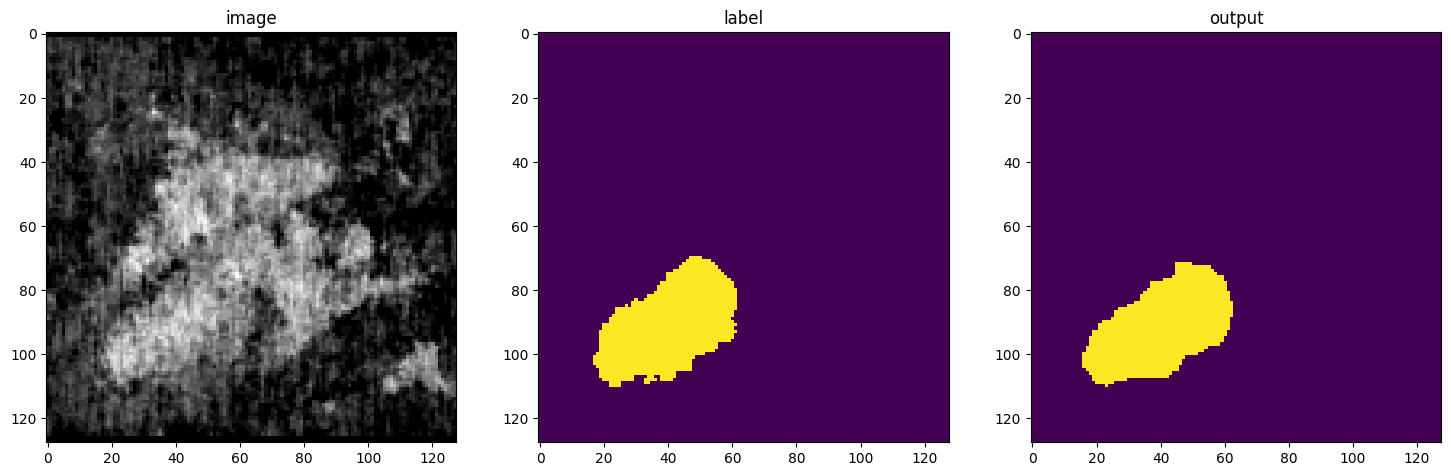

In [19]:
case_num = 4
slice_preview = 64
model.eval()
with torch.no_grad():
    for step, batch in enumerate(train_loader):
        tmp = batch
        break
    val_inputs = tmp["image"].cuda()
    val_labels = tmp["label"].cuda()
    val_outputs = model(val_inputs)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_preview], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_preview])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        post_pred(val_outputs).float().cpu().numpy()[0, 0, :, :, slice_preview]
    )
    plt.show()

In [20]:
example_volume = val_inputs.cpu().numpy()[0, 0, :, :, :]
example_pred = val_outputs.cpu().numpy()[0, 0, :, :, :]
example_seg = val_labels.cpu().numpy()[0, 0, :, :, :]

In [21]:
import nibabel as nib
import numpy as np

In [22]:
dice_test_scores = []
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        tmp = batch
        vol = tmp["image"].cuda()
        label = tmp["label"].cuda()
        pred = post_pred(model(vol))
        dice_score = dice_metric(y_pred=pred, y=label).cpu().numpy()
        dice_test_scores.append(dice_score)
        
        example_volume = vol.cpu().numpy()[0, 0, :, :, :]
        example_pred = pred.cpu().numpy()[0, 0, :, :, :]
        example_seg = label.cpu().numpy()[0, 0, :, :, :]
        
        nib.save(nib.Nifti1Image(example_volume, np.eye(4)), os.path.join(test_data_save_dir, f'test_vol{step}.nii.gz'))  
        nib.save(nib.Nifti1Image(example_pred, np.eye(4)), os.path.join(test_data_save_dir, f'test_pred{step}.nii.gz'))
        nib.save(nib.Nifti1Image(example_seg, np.eye(4)), os.path.join(test_data_save_dir, f'test_seg{step}.nii.gz'))

In [23]:
dice_test_scores = np.array(dice_test_scores).flatten()

In [24]:
mean_dice = np.mean(dice_test_scores)
fig = plt.figure()
plt.title(f'Test Set Dice Scores: (Mean: {mean_dice:0.5f})')
plt.bar(range(1, len(dice_test_scores)+1), dice_test_scores)
plt.axhline(y=mean_dice, color='black', linestyle='--')
plt.xlabel('Test Volume Number')
plt.xticks(ticks=range(1, len(dice_test_scores)+1))
plt.ylabel('Dice Score')

tensorboard_writer.add_figure('Dice/test', fig)

In [25]:
tensorboard_writer.close()

In [26]:
unet_r

False

In [34]:
# Run Segmentation of all Data using the best model
import os
import csv
import nibabel as nib
import numpy as np
from skimage.measure import label

# Get master List of all folders to process
master_file_list = r'C:\Users\Alex\Gitlab_repos\Projects\cardiac-apoe-analysis-utils\master_file_list.csv'
with open(master_file_list, 'r') as f:
    reader = csv.reader(f)
    folder_list = list(reader)

# CT Input
all_files = [[os.path.join(folder[0], 'diastole_resized.nii'), os.path.join(folder[0], 'systole_resized.nii')] for folder in folder_list]
all_files = [file for filelist in all_files for file in filelist]
all_files = [{"image": img_file} for img_file in all_files]
output_files = [[os.path.join(folder[0], 'LV_diastole_resized_CNN_v2.nii.gz'), os.path.join(folder[0], 'LV_systole_resized_CNN_v2.nii.gz')] for folder in folder_list]
output_files = [file for filelist in output_files for file in filelist]

# # Decomp Input
# all_files = [[os.path.join(folder[0], 'diastole_I_resized.nii'), os.path.join(folder[0], 'systole_I_resized.nii')] for folder in folder_list]
# all_files = [file for filelist in all_files for file in filelist]
# all_files = [{"image": img_file} for img_file in all_files]
# output_files = [[os.path.join(folder[0], 'LV_diastole_resized_CNN_I_v2.nii.gz'), os.path.join(folder[0], 'LV_systole_resized_CNN_I_v2.nii.gz')] for folder in folder_list]
# output_files = [file for filelist in output_files for file in filelist]

preprocess_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        NormalizeIntensityd(keys=["image"]),
    ]
)
full_dataset = Dataset(
    data=all_files,
    transform=preprocess_transforms
)

full_data_loader = DataLoader(
    full_dataset, batch_size=1, shuffle=False, num_workers=8
)

post_pred = Compose(
    [Activations(sigmoid=True),
     AsDiscrete(threshold=0.48)])

In [35]:
with torch.no_grad():
    model.eval()
    for step, batch in tqdm(enumerate(full_data_loader)):
        vol = batch["image"].cuda()
        pred = post_pred(model(vol))
        pred = pred.cpu().numpy()[0, 0, :, :, :]
        segments = label(pred)
        pred = segments == np.argmax(np.bincount(segments.flat, weights=pred.flat))
        nib.save(nib.Nifti1Image(pred.astype('float32'), np.eye(4)), output_files[step])
        

246it [01:02,  3.95it/s]


In [36]:
# Run Segmentation of all Data using the best model
import os
import csv
import nibabel as nib
import numpy as np
from glob import glob 

# Now go through and segment all files organized by train, val, test

# CT input
all_files = glob(r'D:\CardiacSegmentationData\*\vol*.nii')
output_files = [file.replace('vol', 'cnn_seg') for file in all_files]
all_files = [{"image": img_file} for img_file in all_files]

# # Decomp input
# all_files = glob(r'D:\CardiacSegmentationData\*\decomp*.nii')
# output_files = [file.replace('decomp', 'I_cnn_seg') for file in all_files]
# all_files = [{"image": img_file} for img_file in all_files]

preprocess_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        NormalizeIntensityd(keys=["image"]),
    ]
)

full_dataset = Dataset(
    data=all_files,
    transform=preprocess_transforms
)

full_data_loader = DataLoader(
    full_dataset, batch_size=1, shuffle=False, num_workers=8
)

post_pred = Compose(
    [Activations(sigmoid=True)])

with torch.no_grad():
    model.eval()
    for step, batch in tqdm(enumerate(full_data_loader)):
        vol = batch["image"].cuda()
        pred = post_pred(model(vol))
        pred = pred.cpu().numpy()[0, 0, :, :, :]
        nib.save(nib.Nifti1Image(pred, np.eye(4)), output_files[step])
        

246it [00:43,  5.65it/s]
